################################################

Owner: Arnab Das
Dataset: CIFAR10

###############################################

## Task 2: Experiments with Regularization
In this task, you will investigate how different regularization techniques affect the training behavior.

Pick a architecture of your choice to train on Cifar10.
Using the same training set, optimizer (and its hyperparameters),
train this architecture first without any regularization, then add different regularizers.
Compare the training and valid/test curves, e.g. regarding:

* training and test accuracy (or loss)
* generalization error, i.e. the gap between train and test (including how strong the overfitting gets)
* difference between when training has converged and at the sweet spot of generalization (smallest gap)

Regularization can be applied to the model (e.g. dropout, L1, L2, added noise) or to the inputs themselves (e.g. rotations, added noise, blurring).

Now choose a different architecture and/or data set and repeat the experiments.
Are the results (qualitatively) still the same? If they are different, discuss potential reasons.

Bonus: Do not only compare visually, but use meaningful quantitative measures for comparison.

## Index

>* Necessary imports
>* Loading Cifar10 dataset
>* Sneak peek into the training images
>* The model
>* Training Experiment 1: **Training with no regularization** 
>* Training process plots and stats
>* Training Experiment 2: **Only L2 regularization**
>* Training process plots and stats
>* Training Experiment 3: **L1 & L2 regularization**
>* Training process plots and stats
>* Training Experiment 4: **Only Dropout**
>* Training process plots and stats
>* Training Experiment 5: **L1, L2 and Dropout regularization**
>* Training process plots and stats
>* Training Experiment 6: **Added noise in training data with L1, L2 and Dropout regularization**
>* Training process plots and stats
>* **Analysis** of above **experiments & comparison**
>* **What's next?**: Performing same experiment with **another more complex model**
>* complex model creation - **Dense Net**
>* **Repeating experiments without and with regularization**  
>* Quatitative and qualitative **comparidon of training process** for the dense net.

In [ ]:
# Importing libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Activation, Conv2DTranspose, Input, AveragePooling2D, concatenate
from keras.regularizers import l2,l1_l2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

#### Loading dataset and printing shapes

In [ ]:
cifar10_dataset = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10_dataset.load_data()

In [ ]:
# Printing the shape for trainining and testing dataset
print("Training images data shape is : {}".format(train_images.shape))
print("Training labels data shape is : {}".format(train_labels.shape))
print("Test images data shape is : {}".format(test_images.shape))
print("Test images data shape is : {}".format(test_labels.shape))

Training images data shape is : (50000, 32, 32, 3)
Training labels data shape is : (50000, 1)
Test images data shape is : (10000, 32, 32, 3)
Test images data shape is : (10000, 1)


##### Reshaping and normalizing training data set

In [ ]:
train_images = train_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255
test_images = test_images.reshape([-1, 32,32, 3]).astype(np.float32) / 255
train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)

### Plotting the first 25 training image from the dataset. 

* This set is a collection of heterogeneous 10 classes. 
* The dataset contain RGB images and they are of share 32*32. Along with a depth of 3.
* Images belong to following classes --> "Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"

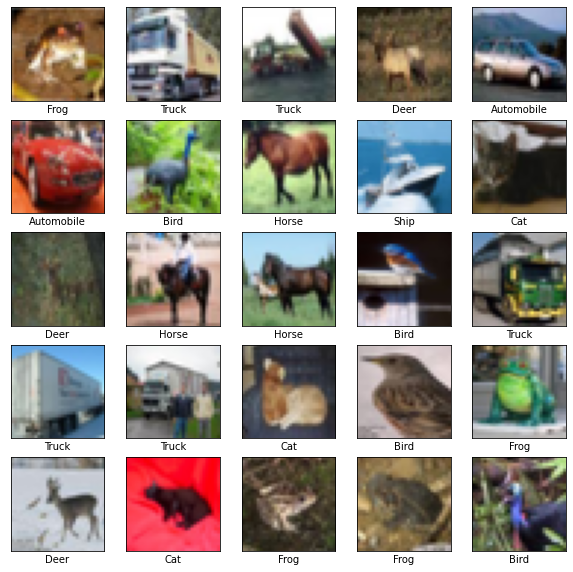

In [ ]:
classes = ["Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"]
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(classes[int(train_labels[i])])
plt.show()

#### Defining the model for the experiments. The model is having convolution and pooling layers in the front and then some fully connected layers.

In [ ]:
# function to return the model
def createModel(regularizer, dropout_rate):
  return Sequential([
    Conv2D(32, 3, padding='same', input_shape = (32,32,3)),
    Activation('relu'),
    Conv2D(64, 3, padding='same'),
    Activation('relu'),
    Conv2D(64, 3 ,  padding = 'same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    Conv2D(128, 3, padding='same'),
    Activation('relu'),
    Conv2D(128, 3, padding = 'same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    Conv2D(256, 3, padding='same', name = 'conv_last'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    Conv2D(512, 3,  padding = 'same'),
    Activation('relu'),
    Conv2D(1024, 3),
    Activation('relu'),
    Flatten(),
    Dropout(dropout_rate),
    Dense(256, activation = 'relu',kernel_regularizer=regularizer),
    Dropout(dropout_rate),
    Dense(512, activation = 'relu',kernel_regularizer=regularizer),
    Dropout(dropout_rate),
    Dense(1024, activation = 'relu',kernel_regularizer=regularizer),
    Dense(10, activation = 'softmax')
    ])

##### Function for model training

In [ ]:
def model_training(test_model):
  training_acc = []
  val_acc = []
  testing_acc = []
  opt = keras.optimizers.Adam()
  test_model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
  for epoch in range(25):
    print("Epoch : ",epoch+1) 
    history = test_model.fit(x=train_images, y=train_labels,batch_size=512, epochs=1, validation_split=0.2, verbose=0)
    training_acc.append(history.history['accuracy'][-1]*100)
    val_acc.append(history.history['val_accuracy'][-1]*100)
    test_loss, test_acc = test_model.evaluate(test_images,  test_labels, verbose=2)
    print('Test accuracy after epoch : {:.2f}'.format(test_acc*100))
    testing_acc.append(test_acc*100)
    print(":------------------------------------------:")
  return training_acc, val_acc, testing_acc

#### Defining some utility funtions for plotting taining curves and statistics

In [ ]:
def plotCurves(training_acc, val_acc, testing_acc):
  plt.figure(figsize=(20,8))
  plt.subplot(1,2,1)
  plt.plot(training_acc )
  plt.plot(val_acc )
  plt.plot(testing_acc )
  plt.title('Model traing, validation, testing accuracy vs epoch')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Val', 'Test'], loc='upper left')
  plt.subplot(1,2,2)
  labels = [testing_acc[i] - training_acc[i] for i in range(len(training_acc))]
  plt.scatter(range(1, len(training_acc)+1),training_acc)
  plt.scatter(range(1, len(training_acc)+1),testing_acc)
  plt.vlines(range(1, len(training_acc)+1), training_acc, testing_acc, colors='r', linestyles= 'solid', label=labels)
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.ylabel('Generalization error')
  plt.xlabel('epoch')
  plt.title('Model Generalization error')
  plt.show()

In [ ]:
import math
def print_stats(training_acc, val_acc, testing_acc):
  print("Final training accuracy after training- {:.2f}%".format(training_acc[-1]))
  print("Testing accuracy after training- {:.2f}%".format(testing_acc[-1]))
  print("Generalization error after training- {:.2f}%".format([training_acc[i]-testing_acc[i] for i in range(len(training_acc))][-1]))
  # Finding the sweet spot
  print("Maximum testing accuracy achieved is : {:.2f}%".format(np.max(testing_acc)))
  sweet_epoch = np.argmin([abs(training_acc[i]-testing_acc[i]) for i in range(len(training_acc))]) +1
  sweet_ge = np.min([abs(training_acc[i]-testing_acc[i]) for i in range(len(training_acc))])
  print("The minimum generalization error is:", round(sweet_ge,2) , "and this happens after epoch", sweet_epoch )
  print("Steps until minimum generalization error", sweet_epoch*(math.ceil(train_images.shape[0]/128)))

### Setting I:

* No regularization
* Training using Adam optimizer
* Batch size 512
* 25 epochs.

In [ ]:
training_acc, val_acc, testing_acc = model_training(createModel(None, 0))

Epoch :  1
313/313 - 1s - loss: 2.1522 - accuracy: 0.1773
Test accuracy after epoch : 17.73
:------------------------------------------:
Epoch :  2
313/313 - 1s - loss: 1.6115 - accuracy: 0.3758
Test accuracy after epoch : 37.58
:------------------------------------------:
Epoch :  3
313/313 - 1s - loss: 1.4164 - accuracy: 0.4685
Test accuracy after epoch : 46.85
:------------------------------------------:
Epoch :  4
313/313 - 1s - loss: 1.2151 - accuracy: 0.5586
Test accuracy after epoch : 55.86
:------------------------------------------:
Epoch :  5
313/313 - 1s - loss: 1.0814 - accuracy: 0.6079
Test accuracy after epoch : 60.79
:------------------------------------------:
Epoch :  6
313/313 - 1s - loss: 0.9619 - accuracy: 0.6577
Test accuracy after epoch : 65.77
:------------------------------------------:
Epoch :  7
313/313 - 1s - loss: 0.9183 - accuracy: 0.6901
Test accuracy after epoch : 69.01
:------------------------------------------:
Epoch :  8
313/313 - 1s - loss: 0.9151 - 

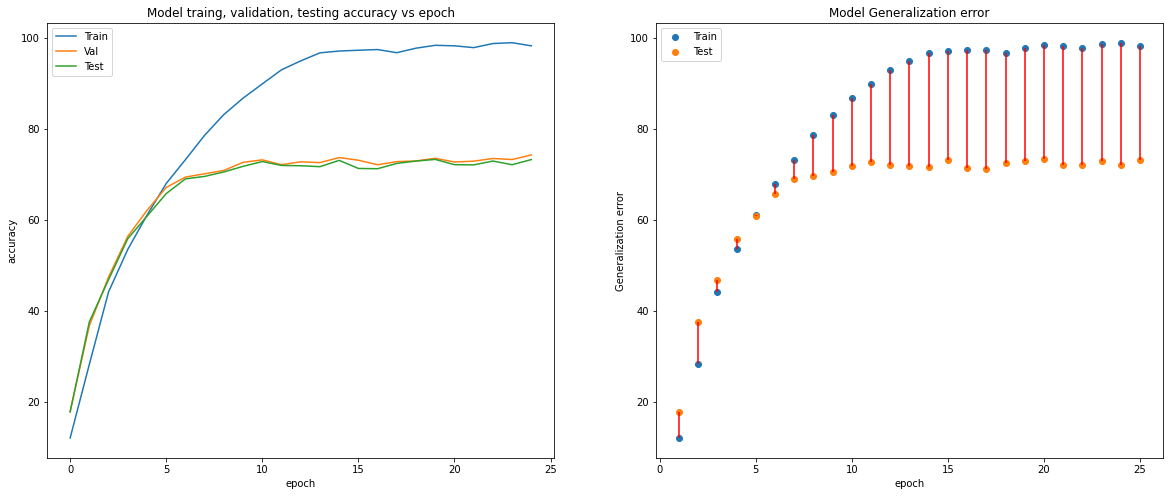

In [ ]:
plotCurves(training_acc, val_acc, testing_acc)

In [ ]:
print_stats(training_acc, val_acc, testing_acc)

Final training accuracy after training- 98.26%
Testing accuracy after training- 73.25%
Generalization error after training- 25.01%
Maximum testing accuracy achieved is : 73.29%
The minimum generalization error is: 0.24 and this happens after epoch 5
Steps until minimum generalization error 1955


### Setting II:

* Added L2 regularization of 0.0005 for dense layers.

In [ ]:
training_acc, val_acc, testing_acc = model_training(createModel(l2(0.0005), 0))

Epoch :  1
313/313 - 1s - loss: 2.0279 - accuracy: 0.2268
Test accuracy after epoch : 22.68
:------------------------------------------:
Epoch :  2
313/313 - 1s - loss: 1.7449 - accuracy: 0.3376
Test accuracy after epoch : 33.76
:------------------------------------------:
Epoch :  3
313/313 - 1s - loss: 1.5281 - accuracy: 0.4448
Test accuracy after epoch : 44.48
:------------------------------------------:
Epoch :  4
313/313 - 1s - loss: 1.3611 - accuracy: 0.5131
Test accuracy after epoch : 51.31
:------------------------------------------:
Epoch :  5
313/313 - 1s - loss: 1.1826 - accuracy: 0.5706
Test accuracy after epoch : 57.06
:------------------------------------------:
Epoch :  6
313/313 - 1s - loss: 1.1663 - accuracy: 0.5946
Test accuracy after epoch : 59.46
:------------------------------------------:
Epoch :  7
313/313 - 1s - loss: 0.9798 - accuracy: 0.6656
Test accuracy after epoch : 66.56
:------------------------------------------:
Epoch :  8
313/313 - 1s - loss: 0.8954 - 

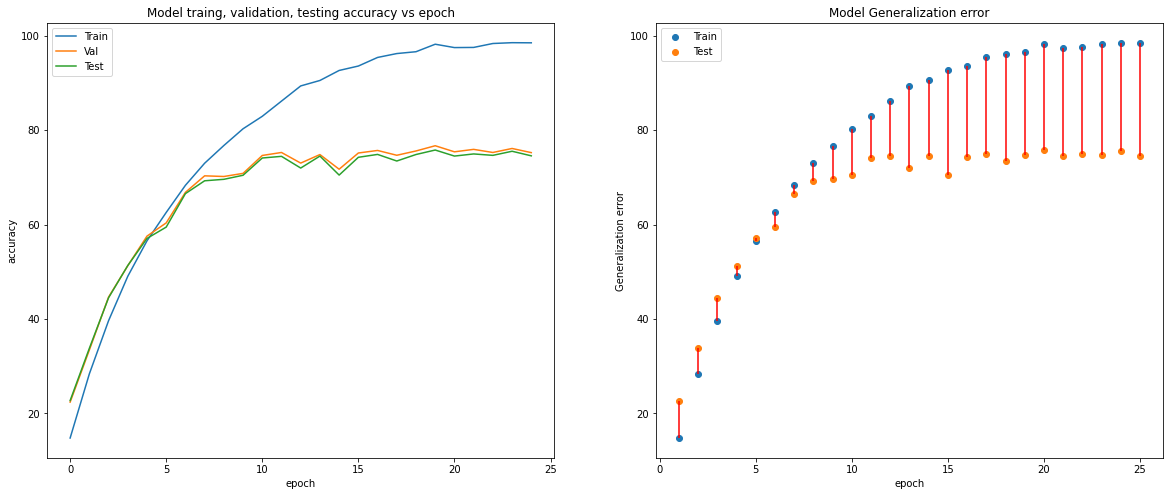

In [ ]:
plotCurves(training_acc, val_acc, testing_acc)

In [ ]:
print_stats(training_acc, val_acc, testing_acc)

Final training accuracy after training- 98.53%
Testing accuracy after training- 74.57%
Generalization error after training- 23.96%
Maximum testing accuracy achieved is : 75.80%
The minimum generalization error is: 0.51 and this happens after epoch 5
Steps until minimum generalization error 1955


### Setting III
* Adding both L1 and L2 regularization

In [ ]:
training_acc, val_acc, testing_acc = model_training(createModel(l1_l2(l1= 0.0005, l2=0.0005), 0))

Epoch :  1
313/313 - 1s - loss: 3.2028 - accuracy: 0.1000
Test accuracy after epoch : 10.00
:------------------------------------------:
Epoch :  2
313/313 - 1s - loss: 2.3882 - accuracy: 0.1988
Test accuracy after epoch : 19.88
:------------------------------------------:
Epoch :  3
313/313 - 1s - loss: 2.0314 - accuracy: 0.2588
Test accuracy after epoch : 25.88
:------------------------------------------:
Epoch :  4
313/313 - 1s - loss: 1.8862 - accuracy: 0.3194
Test accuracy after epoch : 31.94
:------------------------------------------:
Epoch :  5
313/313 - 1s - loss: 1.7938 - accuracy: 0.3600
Test accuracy after epoch : 36.00
:------------------------------------------:
Epoch :  6
313/313 - 1s - loss: 1.8515 - accuracy: 0.3434
Test accuracy after epoch : 34.34
:------------------------------------------:
Epoch :  7
313/313 - 1s - loss: 1.4781 - accuracy: 0.4914
Test accuracy after epoch : 49.14
:------------------------------------------:
Epoch :  8
313/313 - 1s - loss: 1.3766 - 

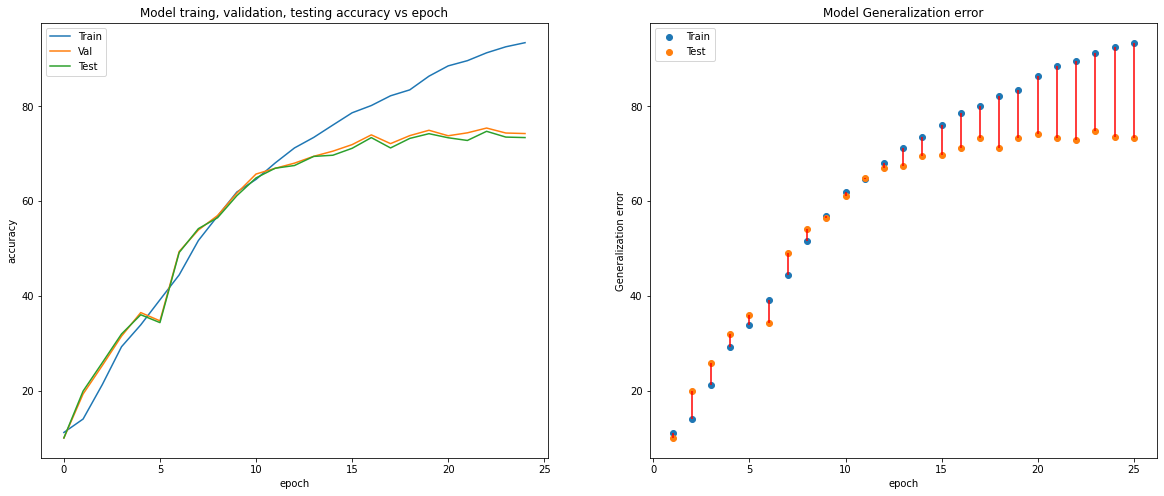

In [ ]:
plotCurves(training_acc, val_acc, testing_acc)

In [ ]:
print_stats(training_acc, val_acc, testing_acc)

Final training accuracy after training- 93.44%
Testing accuracy after training- 73.41%
Generalization error after training- 20.03%
Maximum testing accuracy achieved is : 74.73%
The minimum generalization error is: 0.31 and this happens after epoch 11
Steps until minimum generalization error 4301


### Setting IV:
* Adding dropout of 0.2

In [ ]:
training_acc, val_acc, testing_acc = model_training(createModel(None, 0.2))

Epoch :  1
313/313 - 1s - loss: 1.9975 - accuracy: 0.2699
Test accuracy after epoch : 26.99
:------------------------------------------:
Epoch :  2
313/313 - 1s - loss: 1.6320 - accuracy: 0.3768
Test accuracy after epoch : 37.68
:------------------------------------------:
Epoch :  3
313/313 - 1s - loss: 1.4840 - accuracy: 0.4322
Test accuracy after epoch : 43.22
:------------------------------------------:
Epoch :  4
313/313 - 1s - loss: 1.2908 - accuracy: 0.5387
Test accuracy after epoch : 53.87
:------------------------------------------:
Epoch :  5
313/313 - 1s - loss: 1.0522 - accuracy: 0.6226
Test accuracy after epoch : 62.26
:------------------------------------------:
Epoch :  6
313/313 - 1s - loss: 0.9021 - accuracy: 0.6838
Test accuracy after epoch : 68.38
:------------------------------------------:
Epoch :  7
313/313 - 1s - loss: 0.8839 - accuracy: 0.7026
Test accuracy after epoch : 70.26
:------------------------------------------:
Epoch :  8
313/313 - 1s - loss: 0.8751 - 

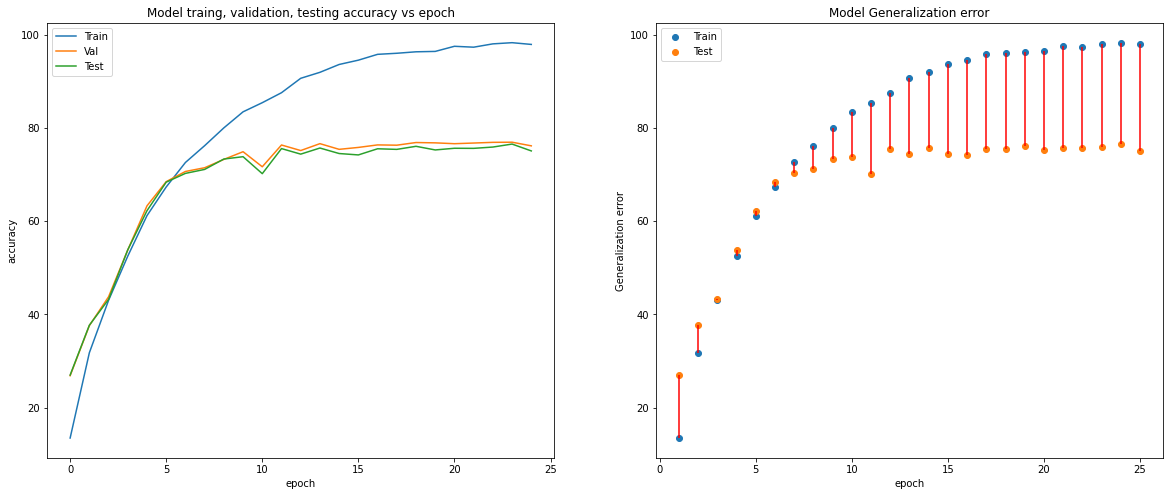

In [ ]:
plotCurves(training_acc, val_acc, testing_acc)

In [ ]:
print_stats(training_acc, val_acc, testing_acc)

Final training accuracy after training- 97.93%
Testing accuracy after training- 75.08%
Generalization error after training- 22.85%
Maximum testing accuracy achieved is : 76.55%
The minimum generalization error is: 0.2 and this happens after epoch 3
Steps until minimum generalization error 1173


### Setting V:

* Adding both dropout and regularization
* L1 and L2 regularization of 0.0005
* Dropout of rate 0.2

In [ ]:
training_acc, val_acc, testing_acc = model_training(createModel(l1_l2(l1=0.0003,l2=0.0005), 0.2))

Epoch :  1
313/313 - 1s - loss: 2.5836 - accuracy: 0.1619
Test accuracy after epoch : 16.19
:------------------------------------------:
Epoch :  2
313/313 - 1s - loss: 2.0338 - accuracy: 0.2432
Test accuracy after epoch : 24.32
:------------------------------------------:
Epoch :  3
313/313 - 1s - loss: 1.8648 - accuracy: 0.2996
Test accuracy after epoch : 29.96
:------------------------------------------:
Epoch :  4
313/313 - 1s - loss: 1.8596 - accuracy: 0.3563
Test accuracy after epoch : 35.63
:------------------------------------------:
Epoch :  5
313/313 - 1s - loss: 1.6419 - accuracy: 0.4279
Test accuracy after epoch : 42.79
:------------------------------------------:
Epoch :  6
313/313 - 1s - loss: 1.6222 - accuracy: 0.4443
Test accuracy after epoch : 44.43
:------------------------------------------:
Epoch :  7
313/313 - 1s - loss: 1.3995 - accuracy: 0.5319
Test accuracy after epoch : 53.19
:------------------------------------------:
Epoch :  8
313/313 - 1s - loss: 1.2998 - 

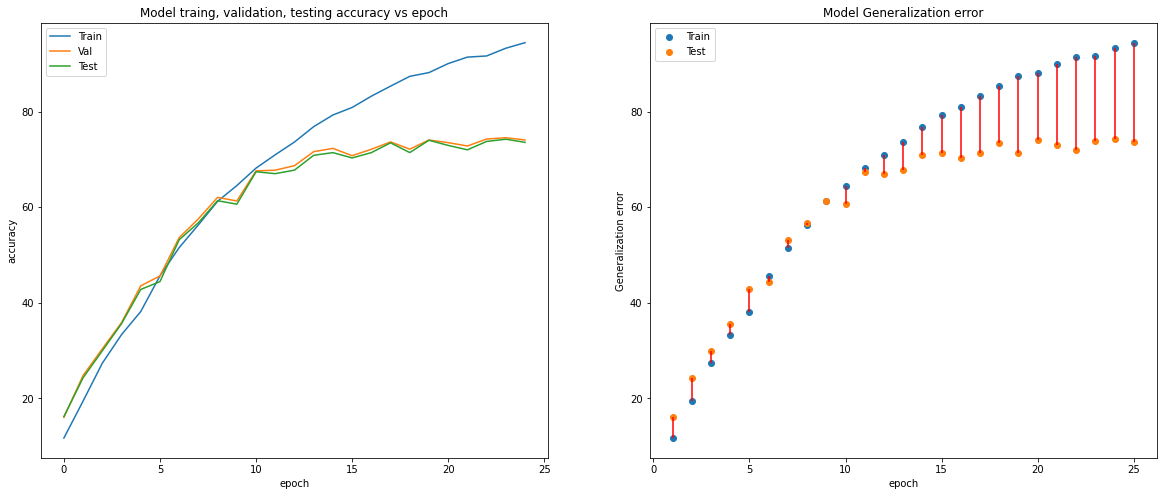

In [ ]:
plotCurves(training_acc, val_acc, testing_acc)

In [ ]:
print_stats(training_acc, val_acc, testing_acc)

Final training accuracy after training- 94.41%
Testing accuracy after training- 73.56%
Generalization error after training- 20.85%
Maximum testing accuracy achieved is : 74.22%
The minimum generalization error is: 0.12 and this happens after epoch 9
Steps until minimum generalization error 3519


### Setting VI:
> As part of this experiment we have used a combination of three regularization technique.
* Added random noise to the training images before normalizing them.
* Used L1,L2 regularization
* Used dropout

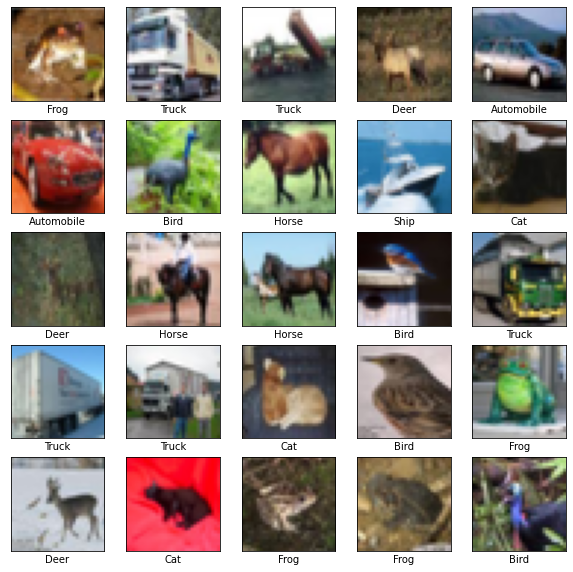

In [ ]:
cifar10_dataset = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10_dataset.load_data()
#train_images=train_images.repeat(2,0)
#train_labels=train_labels.repeat(2,0)
#train_images, train_labels = shuffle_train_data(train_images, train_labels)
train_images = train_images + np.random.normal(0, 0.3)
train_images = train_images.reshape([-1, 32, 32, 3]).astype(np.float32)
train_images = (train_images - np.min(train_images)) / (np.max(train_images) - np.min(train_images))
test_images = test_images.reshape([-1, 32,32, 3]).astype(np.float32) / 255
train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)
classes = ["Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"]
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(classes[int(train_labels[i])])
plt.show()

In [ ]:
training_acc = []
val_acc = []
testing_acc = []
test_model = createModel(l1_l2(l1=0.0005,l2=0.0005), 0.1)
opt = tf.optimizers.Adam()
test_model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
for epoch in range(25):
  print("Epoch : ",epoch+1) 
  history = test_model.fit(train_images, train_labels,batch_size=512, validation_split=0.2, epochs=1, verbose=0)
  training_acc.append(history.history['accuracy'][-1]*100)
  val_acc.append(history.history['val_accuracy'][-1]*100)
  test_loss, test_acc = test_model.evaluate(test_images,  test_labels, verbose=2)
  print('Test accuracy after epoch : {:.2f}'.format(test_acc*100))
  testing_acc.append(test_acc*100)
  print(":------------------------------------------:")

Epoch :  1
313/313 - 2s - loss: 2.3548 - accuracy: 0.2119
Test accuracy after epoch : 21.19
:------------------------------------------:
Epoch :  2
313/313 - 1s - loss: 2.0478 - accuracy: 0.2265
Test accuracy after epoch : 22.65
:------------------------------------------:
Epoch :  3
313/313 - 1s - loss: 1.8272 - accuracy: 0.3600
Test accuracy after epoch : 36.00
:------------------------------------------:
Epoch :  4
313/313 - 1s - loss: 1.6964 - accuracy: 0.4042
Test accuracy after epoch : 40.42
:------------------------------------------:
Epoch :  5
313/313 - 1s - loss: 1.5899 - accuracy: 0.4511
Test accuracy after epoch : 45.11
:------------------------------------------:
Epoch :  6
313/313 - 1s - loss: 1.5237 - accuracy: 0.4956
Test accuracy after epoch : 49.56
:------------------------------------------:
Epoch :  7
313/313 - 1s - loss: 1.3056 - accuracy: 0.5781
Test accuracy after epoch : 57.81
:------------------------------------------:
Epoch :  8
313/313 - 1s - loss: 1.2603 - 

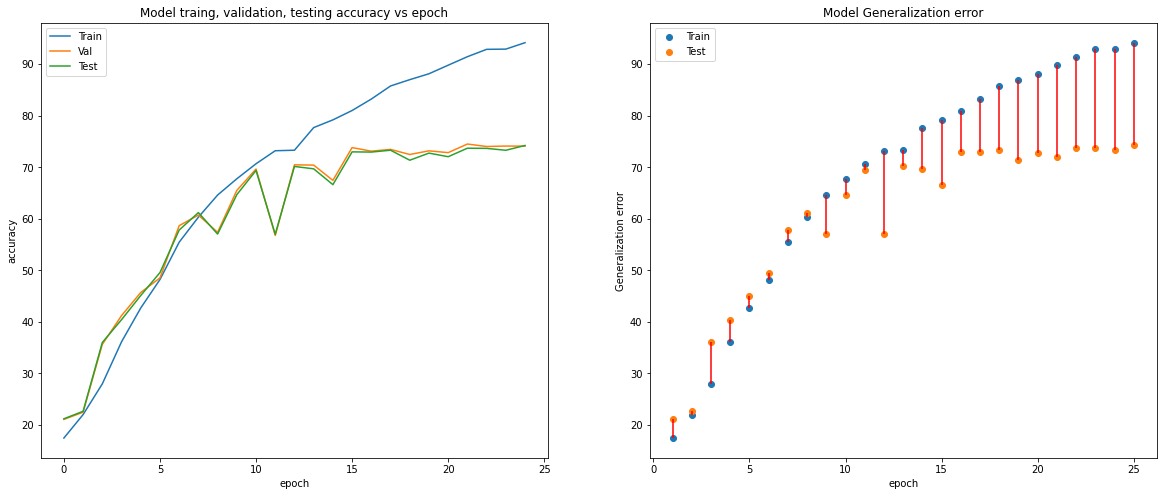

In [ ]:
plotCurves(training_acc, val_acc, testing_acc)

In [ ]:
print_stats(training_acc, val_acc, testing_acc)

Final training accuracy after training- 94.16%
Testing accuracy after training- 74.22%
Generalization error after training- 19.94%
Maximum testing accuracy achieved is : 74.22%
The minimum generalization error is: 0.64 and this happens after epoch 2
Steps until minimum generalization error 782


## Comparison & Analysis:
> As of now we have trained and tested our model under six different settings using different regularizers and their combination. We have also plotted training, validation and testing graphs against epochs. WE have also tried to show generalization error gap between training and testing and gathered information on how big/small the overfitting gets. 
So, what can we infer from those?

1. For the first experiment the model is trained without any regularizers. And training accuracy grows very fast with a steep slope. It rapidly crosses 90% accuracy mark within 10 epochs and by the time the training finishes the training accuracy reaches a whooping 98.26%. On other side the validation or testing accracy following the training curve only upto 5th epoch and then the testing accuracy saturates. Even though the training accuracy kept on growing the testing accuracy doesn't grow anymore. Procuding a gerelization error of >26& at the end of training. This measure also indicates how strong the overfitting is after the training. 

2. After adding only L2 regularization, the training accuracy grows little slowly and saturates after 18epochs. Validation or testing accuracy curve tracks the training accuracy a liitle better upto 8th epoch. Testing accuracy is also boosted a little bit and reaches a maximum of 75.8%. In term of genaralization, this setting produce 2% less gap. And after the training the gap comes down to ~24%, compared to >26% in previous case. The results are still no satisfactory but at least better than previous.

3. After using both L1 and L2 regularization, The training accuracy curve gets further smoothen. And after the complete training of 25 epochs, it reaches upto 93% (>98% in previous two occassions). Now the testing accuracy curve follows neck to neck the training accuracy curve upto 12 epochs. The generalization gap further comes down to ~20% till traing process finishes. Hence under this setting, the model shows better geeralization compared to previous settings.

4. In this setting we have only used dropout for the inputs of dense layers with rate 0.2. Under this setting the traning accuracy curve get saturated after 16th Epoch producng ~98% training accuracy after comlete training. The testing accuracy curve keep a track upto 7th Epoch then it saturates, producing a gap of 22.85 % in terms of traning and testing accuracy. So as far as the overfitting is concerned, this model performs better than the model with no regularization. 

> What if we combine these two techniques?

5. When we used both l1, l2 and dropout, the training curve does gets saturated at all. It kept on growing untill the last epoch following a less steeper curve. At the end the training accuracy reaches 94%. The testing curve kept following the training accuracy upto 11th epoch. this setting produces a genalization gap of ~20% till the training process ends.

6. In this setting we added noise in the input training images itself as another method of achieving regularization. Under this setting, the training accuracy curve remains smooth and doesn't show any elbow pattern. The training accuracy reaches ~94%, and the tesing accuracy keeps track upto 13th epoch. This setting also reduces the generalization gap further 1% and at the end of training process a overfitting gap of ~19% remains.

> So in conclusion we can certainly say that using regularizers certainly improves traning process. Using regularization techniques we can achieve a model which is less overfitted and more generalized in nature.

---


## What's next?

Will this inference hold for a more complex model?

No now further extend our experiment to a very deep Dense Net model and visualize the taining process.



#### Defining model architecture i.e. dense blocks, extended dence blocks , and overall model

In [ ]:
def denseBlock( depth, inp, k_size= 3, growth= 12 ):
  act_layer = Activation('relu')
  ip = inp
  for layer in range(1, depth+1):
    op = act_layer(ip)
    op = Conv2D(growth*4, 1, padding="same")(op)
    op = act_layer(op)
    op = Conv2D(growth, k_size, padding="same")(op)
    ip = concatenate([ip, op])
  return ip 

In [ ]:
def extenDenseBlock(depth, k_size, inp, dense_depth,theta = 1, growth= 12):
  ip = inp
  for layers in range (1, depth +1):
    op = denseBlock( dense_depth[layers -1],ip, k_size,growth )
    op = Activation('relu')(op)
    op = Conv2D(op.shape[-1]*theta, 1, padding="same")(op)
    op = AveragePooling2D(pool_size=(2, 2))(op)
    ip = op
  return ip;   


In [ ]:
def denseModel(input_shape, f_size, init_depth, trans_block_depth, theta, dense_depth, growth, dense_block_f, final_dense_depth, dropout_rate= 0, regularizer=None):
  x_inp = Input(input_shape)
  x = Conv2D(init_depth, f_size, padding = "same", use_bias=False)(x_inp)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = extenDenseBlock(trans_block_depth, dense_block_f,  x, dense_depth,theta,growth)
  x = denseBlock(dense_block_f, x,final_dense_depth, growth)
  x = AveragePooling2D(pool_size=(2, 2), strides=(1,1))(x)
  x = Flatten()(x)
  x=  Dropout(dropout_rate)(x)
  x = Dense(256, activation = 'relu', kernel_regularizer=regularizer)(x)
  x=  Dropout(dropout_rate)(x)
  x = Dense(10, kernel_regularizer=regularizer,activation = 'softmax')(x)
  
  # Create model
  myDensemodel = Model(inputs = x_inp, outputs = x, name='DenseNetModel')
  return myDensemodel

### Setting I:
* Dense Net model
* No regularization

In [ ]:
training_acc = []
val_acc = []
testing_acc = []
mydenseModel = denseModel((32, 32, 3), 3,64,3,1,[6, 12, 12], 12, 2,12)
mydenseModel.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
for epoch in range(25):
  print("Epoch : ",epoch+1) 
  history = mydenseModel.fit(train_images, train_labels,batch_size=512, validation_split=0.2, epochs=1, verbose=0)
  training_acc.append(history.history['accuracy'][-1]*100)
  val_acc.append(history.history['val_accuracy'][-1]*100)
  test_loss, test_acc = mydenseModel.evaluate(test_images,  test_labels, verbose=2)
  print('Test accuracy after epoch : {:.2f}'.format(test_acc*100))
  testing_acc.append(test_acc*100)
  print(":------------------------------------------:")

Epoch :  1
313/313 - 2s - loss: 1.8829 - accuracy: 0.2951
Test accuracy after epoch : 29.51
:------------------------------------------:
Epoch :  2
313/313 - 2s - loss: 1.6621 - accuracy: 0.3721
Test accuracy after epoch : 37.21
:------------------------------------------:
Epoch :  3
313/313 - 2s - loss: 1.4876 - accuracy: 0.4506
Test accuracy after epoch : 45.06
:------------------------------------------:
Epoch :  4
313/313 - 2s - loss: 1.5689 - accuracy: 0.4346
Test accuracy after epoch : 43.46
:------------------------------------------:
Epoch :  5
313/313 - 2s - loss: 1.3419 - accuracy: 0.5070
Test accuracy after epoch : 50.70
:------------------------------------------:
Epoch :  6
313/313 - 2s - loss: 1.3144 - accuracy: 0.5221
Test accuracy after epoch : 52.21
:------------------------------------------:
Epoch :  7
313/313 - 2s - loss: 1.2202 - accuracy: 0.5476
Test accuracy after epoch : 54.76
:------------------------------------------:
Epoch :  8
313/313 - 2s - loss: 1.1625 - 

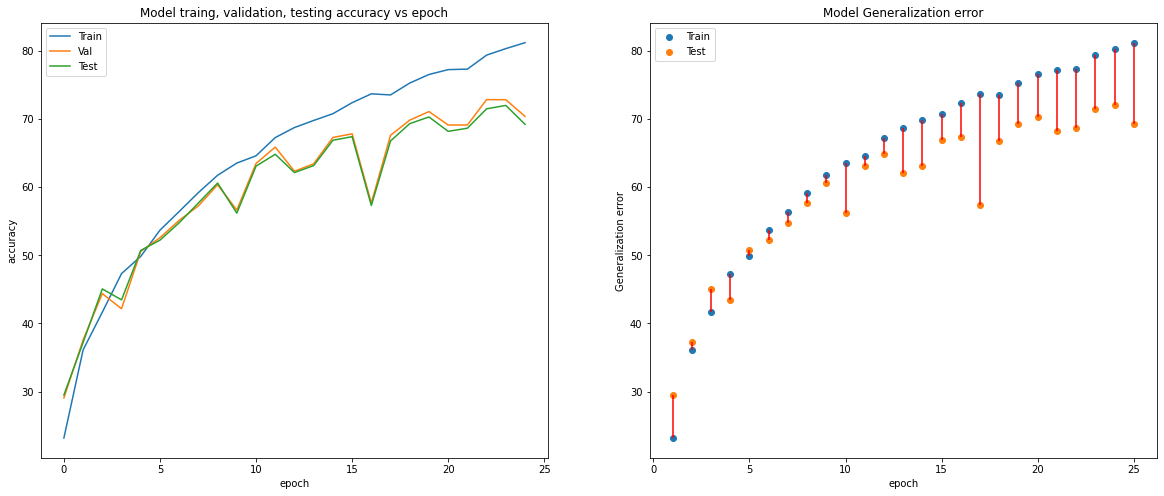

In [ ]:
plotCurves(training_acc, val_acc, testing_acc)

In [ ]:
print_stats(training_acc, val_acc, testing_acc)

Final training accuracy after training- 81.16%
Testing accuracy after training- 69.19%
Generalization error after training- 11.97%
Maximum testing accuracy achieved is : 71.96%
The minimum generalization error is: 0.87 and this happens after epoch 5
Steps until minimum generalization error 1955


### Setting II:
* Same Dense net model
* Added dropout 0.2
* Added L1,L2 regularization

In [ ]:
training_acc = []
val_acc = []
testing_acc = []
rgrlzd_denseModel = denseModel((32, 32, 3), 3,64,3,1,[6, 12, 12], 12, 2,12, 0.2, l1_l2(l1=0.0005, l2=0.0005))
rgrlzd_denseModel.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
for epoch in range(25):
  print("Epoch : ",epoch+1) 
  history = rgrlzd_denseModel.fit(train_images, train_labels,batch_size=512, validation_split=0.2, epochs=1, verbose=0)
  training_acc.append(history.history['accuracy'][-1]*100)
  val_acc.append(history.history['val_accuracy'][-1]*100)
  test_loss, test_acc = rgrlzd_denseModel.evaluate(test_images,  test_labels, verbose=2)
  print('Test accuracy after epoch : {:.2f}'.format(test_acc*100))
  testing_acc.append(test_acc*100)
  print(":------------------------------------------:")

Epoch :  1
313/313 - 2s - loss: 2.3567 - accuracy: 0.2824
Test accuracy after epoch : 28.24
:------------------------------------------:
Epoch :  2
313/313 - 2s - loss: 1.8964 - accuracy: 0.3538
Test accuracy after epoch : 35.38
:------------------------------------------:
Epoch :  3
313/313 - 2s - loss: 2.0660 - accuracy: 0.2815
Test accuracy after epoch : 28.15
:------------------------------------------:
Epoch :  4
313/313 - 2s - loss: 1.6959 - accuracy: 0.3990
Test accuracy after epoch : 39.90
:------------------------------------------:
Epoch :  5
313/313 - 2s - loss: 1.5855 - accuracy: 0.4377
Test accuracy after epoch : 43.77
:------------------------------------------:
Epoch :  6
313/313 - 2s - loss: 1.4540 - accuracy: 0.4919
Test accuracy after epoch : 49.19
:------------------------------------------:
Epoch :  7
313/313 - 2s - loss: 1.4070 - accuracy: 0.5118
Test accuracy after epoch : 51.18
:------------------------------------------:
Epoch :  8
313/313 - 2s - loss: 1.3347 - 

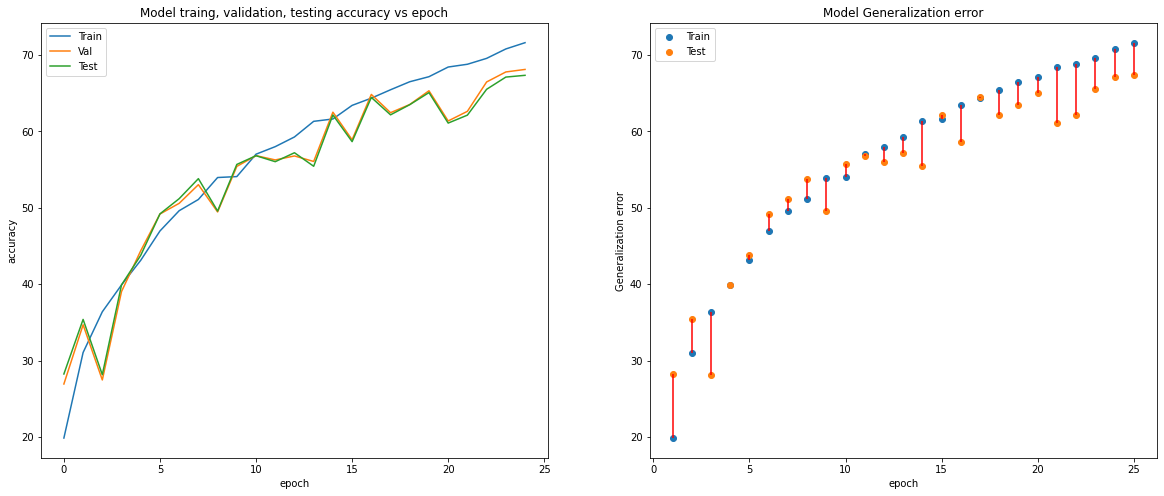

In [ ]:
plotCurves(training_acc, val_acc, testing_acc)

In [ ]:
print_stats(training_acc, val_acc, testing_acc)

Final training accuracy after training- 71.59%
Testing accuracy after training- 67.32%
Generalization error after training- 4.27%
Maximum testing accuracy achieved is : 67.32%
The minimum generalization error is: 0.0 and this happens after epoch 4
Steps until minimum generalization error 1564


## Analysis:
 > Again the experiment prove the theory and follow the trend of earlier experiments.

 > At first when we trained this dense net model without any regularizer, the testing curves tracks the training accuracy curve only upto 12th epoch. the model gets overfitted to training data and produces >81% training accuracy at the end of 25 epochs. Whereas the  testing accuracy remains around 70% boundary. After complete 25 epochs of training the model shows a 12% gap between training and testing accuracy, which incates the model overfitting strength.

 > In second setting when the same model is trained with L1,l2 and dropout, things get better, The training process bars the traning accuracy go very high and prodces a less steep traning curve. The traning accracy only gets as high as 71.6%. And the testing accuracy tracs al the way upto 21st epoch. After that also the overfitting doesn't get very strong. The testing accuracy reaches >67% after the training. And the genaralization gap comes down to mere 4.2% at the end of traning. Which is way betther than the setting with no regularization.

Hence we can certainly say that while designing our model one should use different regularization techniques to achieve better genralized model to imply on unseen data.

---